REQUIRED MODULE IMPORTING

In [56]:
import zipfile
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

EXTRACTION OF THE DATASET CRPLUS

In [57]:
# Define the path
zip_path = "/content/drive/MyDrive/CRPLUS.zip"
extract_path = "/content/CKPlus"

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete! Files are available at:", extract_path)


Extraction complete! Files are available at: /content/CKPlus


In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Knowing the count of each emotion

In [59]:
# Define dataset path
dataset_path = "/content/CKPlus/CK+48"

# List emotion categories
emotion_folders = os.listdir(dataset_path)
print("Emotions in dataset:", emotion_folders)

# Count images per emotion
emotion_counts = {folder: len(os.listdir(os.path.join(dataset_path, folder))) for folder in emotion_folders}
print("Image Count per Emotion:", emotion_counts)


Emotions in dataset: ['fear', 'anger', 'contempt', 'surprise', 'happy', 'sadness', 'disgust']
Image Count per Emotion: {'fear': 75, 'anger': 135, 'contempt': 54, 'surprise': 249, 'happy': 207, 'sadness': 84, 'disgust': 177}


KNOWING THE RESOLUTION OF THE IMAGE

In [60]:
def get_distinct_image_sizes(dataset_path, num_samples=10):
    image_sizes = set()  # Use a set to store distinct resolutions

    for emotion in os.listdir(dataset_path):
        emotion_folder = os.path.join(dataset_path, emotion)
        images = os.listdir(emotion_folder)[:num_samples]

        for img_name in images:
            img_path = os.path.join(emotion_folder, img_name)
            img = cv2.imread(img_path)

            if img is not None:
                image_sizes.add(img.shape)  # Add the shape to the set

    return image_sizes

# Get distinct image sizes
distinct_sizes = get_distinct_image_sizes(dataset_path)
print("Distinct Image Dimensions:", distinct_sizes)

Distinct Image Dimensions: {(48, 48, 3)}


EDA By Ploting the each and every emotion

<ipython-input-61-84bcadb3f2b4>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(emotion_counts.keys()), y=list(emotion_counts.values()), palette="coolwarm")


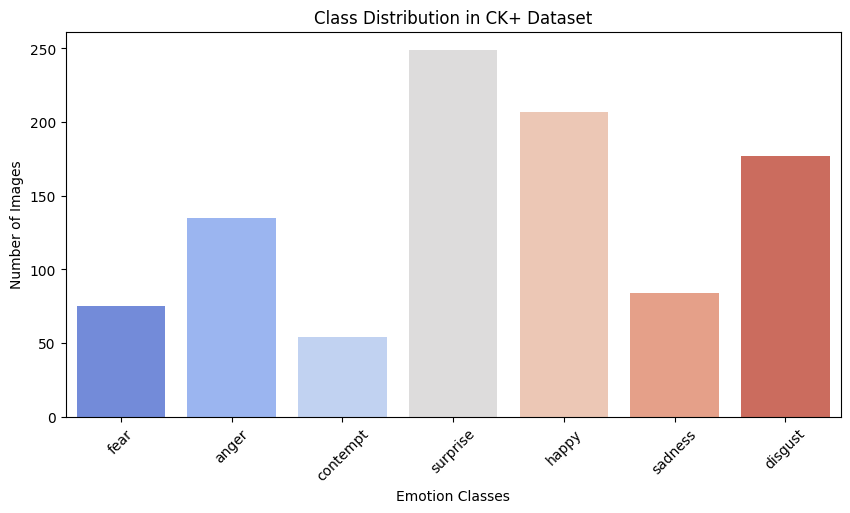

In [61]:
# Plot emotion distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=list(emotion_counts.keys()), y=list(emotion_counts.values()), palette="coolwarm")
plt.xlabel("Emotion Classes")
plt.ylabel("Number of Images")
plt.title("Class Distribution in CK+ Dataset")
plt.xticks(rotation=45)
plt.show()


Imbalanced Dataset: Some emotions (e.g., surprise, happy) have significantly more images than others (contempt, fear, sadness), which may lead to model bias.

Underrepresented Classes: Emotions like contempt and fear have fewer images, potentially reducing model accuracy for these categories.

Overrepresented Classes: The model may overpredict surprise and happy due to their higher representation.

Impact on Model Performance: Imbalance may lead to poor classification of rare emotions. Solutions like data augmentation, oversampling, or class-weighted loss can improve fairness and accuracy.

DISplaying sample images

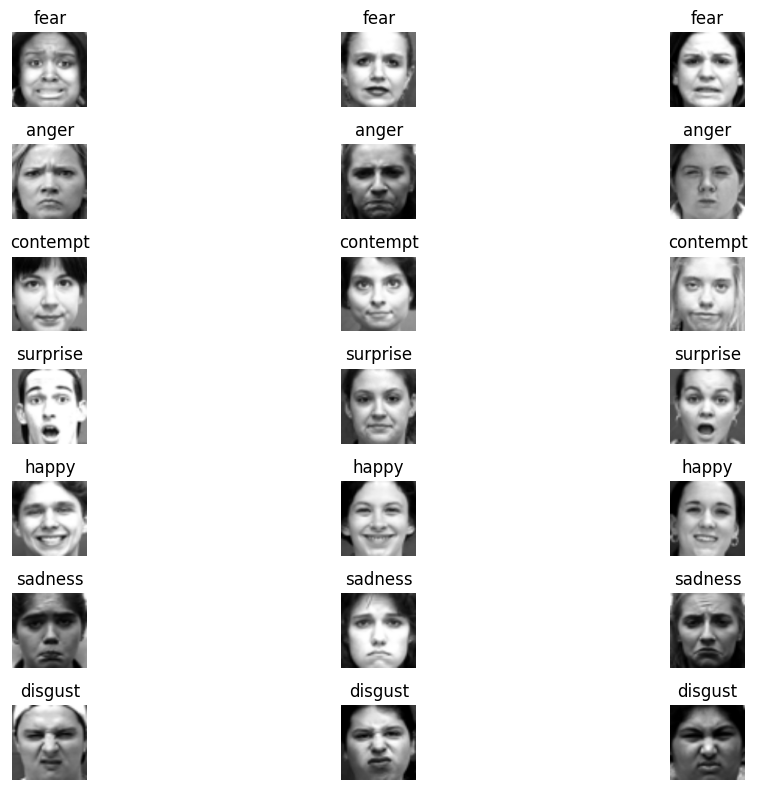

In [62]:
import cv2
import numpy as np

def display_samples(dataset_path, emotion_folders, samples_per_emotion=3):
    plt.figure(figsize=(12, 8))
    i = 1
    for emotion in emotion_folders:
        folder_path = os.path.join(dataset_path, emotion)
        images = os.listdir(folder_path)[:samples_per_emotion]

        for img_name in images:
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
            img = cv2.resize(img, (100, 100))  # Resize to 100x100

            plt.subplot(len(emotion_folders), samples_per_emotion, i)
            plt.imshow(img, cmap="gray")
            plt.axis("off")
            plt.title(emotion)
            i += 1

    plt.tight_layout()
    plt.show()

display_samples(dataset_path, emotion_folders)

AUGUMENTION OF DATA

In [63]:
import os
import shutil
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define dataset paths
dataset_path = "/content/CKPlus/CK+48"
augmented_dataset_path = "/content/Augmented"

# Create directory for augmented dataset
os.makedirs(augmented_dataset_path, exist_ok=True)

# List emotion categories
emotion_folders = os.listdir(dataset_path)

# Count images per emotion
emotion_counts = {folder: len(os.listdir(os.path.join(dataset_path, folder))) for folder in emotion_folders}
max_images = max(emotion_counts.values())  # Target count for balancing

# Define augmentation transformations
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to augment images with diverse transformations
def augment_images(image_path, save_folder, augment_count):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    i = 0
    for batch in datagen.flow(image, batch_size=1, save_to_dir=save_folder, save_prefix="aug", save_format="png"):
        i += 1
        if i >= augment_count:
            break

# Balance dataset with diverse augmentation
for emotion in emotion_folders:
    original_folder = os.path.join(dataset_path, emotion)
    new_folder = os.path.join(augmented_dataset_path, emotion)
    os.makedirs(new_folder, exist_ok=True)

    # Copy original images first
    images = os.listdir(original_folder)
    for img in images:
        shutil.copy(os.path.join(original_folder, img), new_folder)

    num_images = len(images)
    if num_images < max_images:
        additional_needed = max_images - num_images
        unique_images = list(set(images))  # Ensure unique selections

        # Augment each image at least once before duplication
        for img in unique_images:
            augment_count = min(additional_needed, 2)  # Avoid excessive augmentation per image
            augment_images(os.path.join(original_folder, img), new_folder, augment_count)
            additional_needed -= augment_count
            if additional_needed <= 0:
                break

print("Dataset Balancing Complete. Images are saved in:", augmented_dataset_path)

Dataset Balancing Complete. Images are saved in: /content/Augmented


Visulazing the after augumention

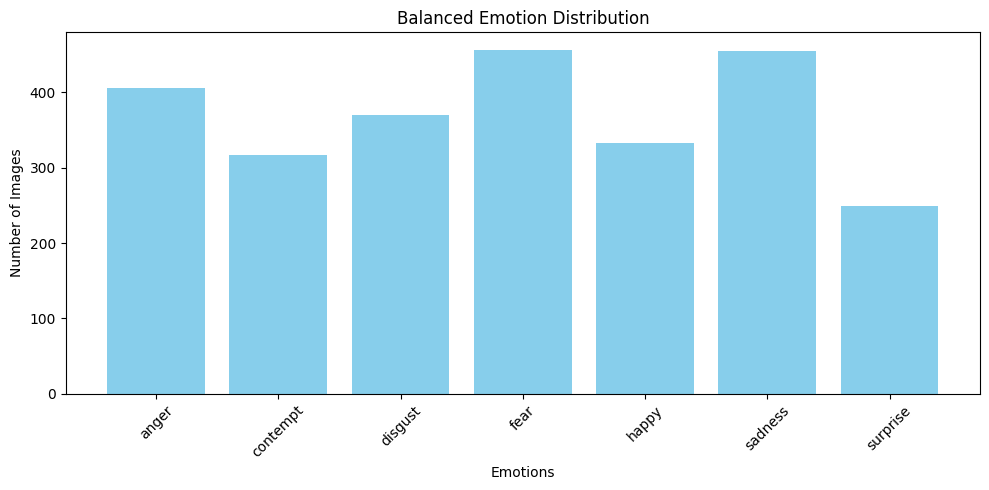

In [64]:
import matplotlib.pyplot as plt
import cv2
import os

# Path to augmented dataset
data_path = "/content/Augmented"
emotion_classes = sorted(os.listdir(data_path))

# 1. Plot class distribution
emotion_counts = {emotion: len(os.listdir(os.path.join(data_path, emotion))) for emotion in emotion_classes}

plt.figure(figsize=(10, 5))
plt.bar(emotion_counts.keys(), emotion_counts.values(), color='skyblue')
plt.title("Balanced Emotion Distribution")
plt.xlabel("Emotions")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()





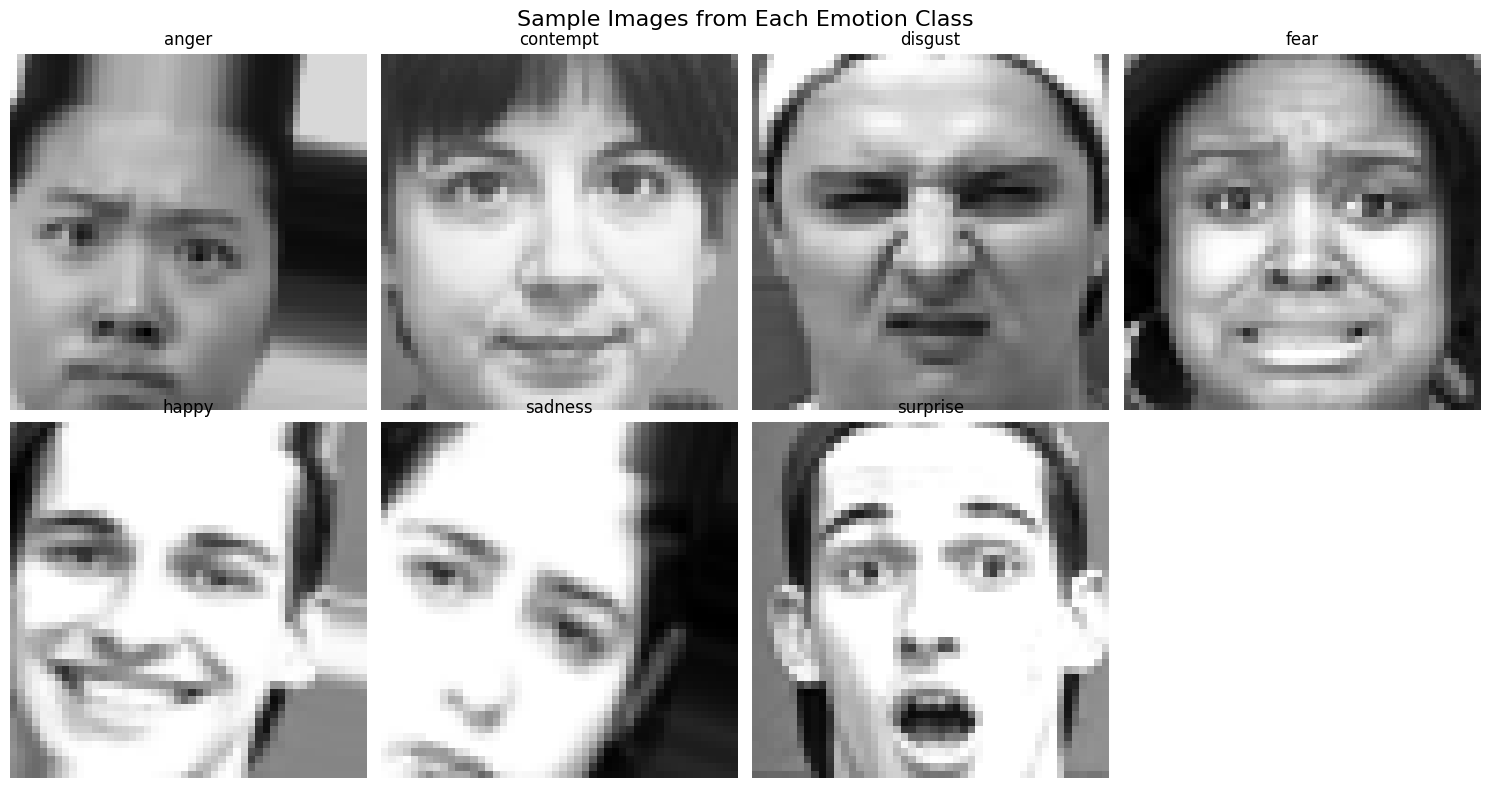

In [65]:
# 2. Show sample images from each class
plt.figure(figsize=(15, 8))
for idx, emotion in enumerate(emotion_classes):
    folder = os.path.join(data_path, emotion)
    image_files = os.listdir(folder)
    image_path = os.path.join(folder, image_files[0])
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, len(emotion_classes) // 2 + 1, idx + 1)
    plt.imshow(img)
    plt.title(emotion)
    plt.axis("off")
plt.suptitle("Sample Images from Each Emotion Class", fontsize=16)
plt.tight_layout()
plt.show()

spliting the data

In [66]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import cv2
import os

# Define dataset path
dataset_path = "/content/Augmented"

# Function to load and preprocess images
def load_and_preprocess_images(dataset_path):
    images = []
    labels = []
    for emotion_folder in os.listdir(dataset_path):
        emotion_path = os.path.join(dataset_path, emotion_folder)
        for image_file in os.listdir(emotion_path):
            image_path = os.path.join(emotion_path, image_file)
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img = cv2.resize(img, (48, 48))  # Resize
            images.append(img)
            labels.append(emotion_folder)
    return np.array(images), np.array(labels)

# Load and preprocess
images, labels = load_and_preprocess_images(dataset_path)

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded, num_classes=7)

indices = np.arange(images.shape[0])
np.random.seed(42)
np.random.shuffle(indices)

images = images[indices]
labels_categorical = labels_categorical[indices]

# Split: 80% train, 10% val, 10% test
X_train, X_temp, y_train, y_temp = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training Samples: {len(X_train)}, Validation Samples: {len(X_val)}, Testing Samples: {len(X_test)}")


Training Samples: 2069, Validation Samples: 259, Testing Samples: 259


CNN MODEL

In [67]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define the number of classes (emotions)
num_classes = 7  # Assuming you have 7 emotion classes

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Now num_classes is defined
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)                   │ (None, 46, 46, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 46, 46, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 21, 21, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 357,319 (1.36 MB)

 Trainable params: 356,871 (1.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [68]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train.argmax(axis=1)), # Assuming y_train is one-hot encoded
                                     y=y_train.argmax(axis=1))

# Convert to dictionary format required by model.fit()
class_weights_dict = dict(enumerate(class_weights))

# Train the model with class weights
history = model.fit( # Changed cnn2d_model to model
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,  # Increase for better accuracy
    batch_size=32,
    class_weight=class_weights_dict,  # Added class weights here
    verbose=1
)

# Save the trained model
model.save("facial_expression_model_with_class_weights.h5") # Changed cnn2d_model to model
print("Model training completed and saved successfully with class weights!")

Epoch 1/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.2549 - loss: 2.6753 - val_accuracy: 0.2857 - val_loss: 1.8254
Epoch 2/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4436 - loss: 1.4017 - val_accuracy: 0.4826 - val_loss: 1.4239
Epoch 3/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5106 - loss: 1.1806 - val_accuracy: 0.4981 - val_loss: 1.2700
Epoch 4/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5806 - loss: 1.0133 - val_accuracy: 0.5714 - val_loss: 1.1625
Epoch 5/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6515 - loss: 0.8680 - val_accuracy: 0.5753 - val_loss: 1.0754
Epoch 6/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6952 - loss: 0.7132 - val_accuracy: 0.5985 - val_loss: 1.0211
Epoch 7/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7479 - loss: 0.6067 - val_accuracy: 0.6023 - val_loss: 1.0496
Epoch 8/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7735 - loss: 0.5641 - val_accuracy: 0.5328 - val_los

Model training completed and saved successfully with class weights!


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7620 - loss: 0.6688 
 Test Accuracy: 72.97%
 Test Loss: 0.8107
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step

🔹 Classification Report:

              precision    recall  f1-score   support

        fear       0.65      0.74      0.69        35
       anger       0.55      0.88      0.68        26
    contempt       0.58      0.88      0.70        34
    surprise       0.86      0.50      0.63        48
       happy       0.84      0.84      0.84        32
     sadness       0.85      0.57      0.68        58
     disgust       1.00      1.00      1.00        26

    accuracy                           0.73       259
   macro avg       0.76      0.77      0.75       259
weighted avg       0.77      0.73      0.73       259



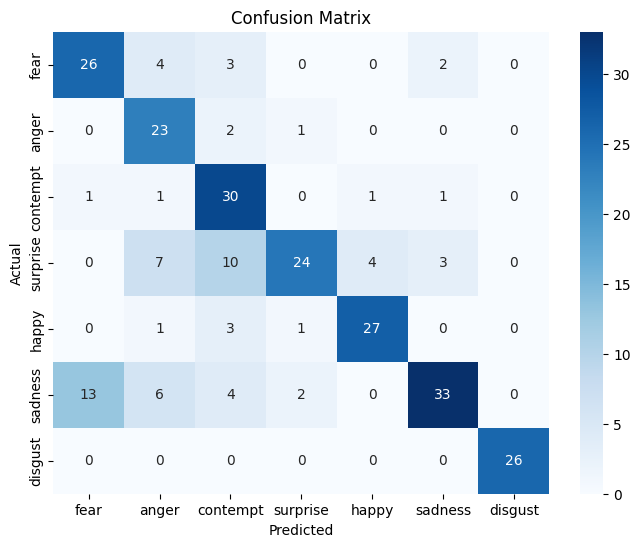

In [69]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on test data
# Changed 'cnn2d_model' to 'model'
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f" Test Accuracy: {test_accuracy * 100:.2f}%")
print(f" Test Loss: {test_loss:.4f}")

# Get predictions
# Changed 'cnn2d_model' to 'model'
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoding to class labels

# Assuming emotion_folders contains the labels (e.g., ['anger', 'disgust', 'fear', ...])
emotion_labels = emotion_folders

# Print Classification Report
print("\n🔹 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=emotion_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Fear vs. Surprise Confusion

4 instances of fear were misclassified as surprise.

Possible Reason: Both emotions involve raised eyebrows, making feature extraction tricky.

Anger Misclassification

Anger is often confused with surprise (5 times) and sadness (2 times).

Possible Reason: The mouth shape and eye squint may resemble those of surprise in some cases.

Surprise Misclassification

Surprise was confused with contempt (2 times) and happy (3 times).

Possible Reason: Open-mouthed surprise may share visual cues with smiles.

Sadness & Anger Confusion

 sadness classified as anger.

Possible Reason: Downturned mouth corners and furrowed brows are present in both.

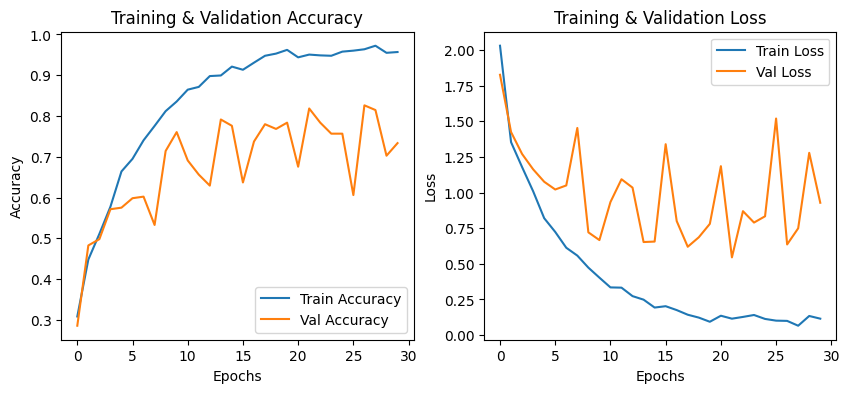

In [70]:
# Plot Training & Validation Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy")

# Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")

plt.show()


Accuracy Trends :

The training accuracy steadily improves, reaching near 100%, suggesting strong learning.

Validation accuracy improves but plateaus around 80-85%, indicating a possible performance ceiling

Loss Trends :

The training loss drops consistently, showing proper model optimization.
